# An intro to Gaussian Processes: Implementing a Basic GP From Scratch

### Introduction

Welcome to this introduction to Gaussian Processes (GPs)! GPs provide some powerful tools for conducting inference, and bring a lot to the table that many other machine learning simply are unable to. Namely, GPs can model complex functions, making them extremely flexible, as well as track our uncertainty at all points in time.

A GP is completely defined by its mean function $\mu$ and its kernel function $k$.

$$ f(x) \sim GP\big(\mu(x),k(x,x')\big)$$

We will assume the mean to be zero, which is often done. The kernel function defines the covariance between the GPs random variables $cov\big(f(x),f(x')\big) = k(x,x')$. Given the kernel defines a covariance, it must produce a positive semi-definite matrix when applied to the input $X$.

For the kernel function, we will implement the basic Squared Exponential Kernel: 
$$k(x,x') = \sigma_{f}^2e^{\frac{-1}{2l}(x-x')^2}$$
Ignore $\sigma_{f}^2$, and $l$ for now. These are hyperparameters that can be tuned to improve your model, however this is beyond the scope of this introduction. We may look at how changing these values ourselves can affect the model later on.

### Lets borrow some code

In [1]:
using Random, Distributions, LinearAlgebra, Plots
rng = Random.seed!(1234)

MersenneTwister(1234)

### The Building Blocks

We assume our mean to be zero so all we need to do is build our kernel function that will be used to construct our covariance matrix. As mentioned above we are using the Squared Exponential kernel.

In [2]:
function SE_kernel(x, x′; σ=1, ℓ=1)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel (generic function with 1 method)

### Define a GP in Julia

We start by defining a new `GP` type to represent our model.

In [3]:
struct GP
    # mean = 0
    kernel
end

In [4]:
gp = GP(SE_kernel)

GP(SE_kernel)

### Construct a Covariance Matrix and Cross-Covariance Matrix

While these could very well have just been a single method, I separated them into two to take advantage of the symmetry found in covariance matrices to quite trivially minimize some computation.

In [5]:
function cov_mat(gp::GP, xs)
    len = length(xs)
    K = zeros(len,len)
    for i in 1:len
        for j in i:len
            K[i,j] = gp.kernel(xs[i],xs[j])
            K[j,i] = K[i,j]
        end
    end
    # we add noise to ensure positive definiteness
    σ = 1e-6
    return K + σ*I
end

cov_mat (generic function with 1 method)

In [6]:
function x_cov_mat(gp::GP, X, X′)
    size= length(X)
    size′= length(X′)
    K =zeros(size,size′)
    for i in 1:size
        for j in 1:size′
            K[i,j] = gp.kernel(X[i],X′[j])
        end
    end
    # we add noise to ensure positive definiteness
    return K
end

x_cov_mat (generic function with 1 method)

### Prior

Here we build a method to draw samples from the prior distribution of our GP.

In [7]:
function sample_prior(xs, num_samples, gp)
    Σ = cov_mat(gp, xs)
    μ = zeros(length(Σ[1,:]))
    ys = rand(MvNormal(μ, Σ), num_samples)
    plot(xs, ys)
end

sample_prior (generic function with 1 method)

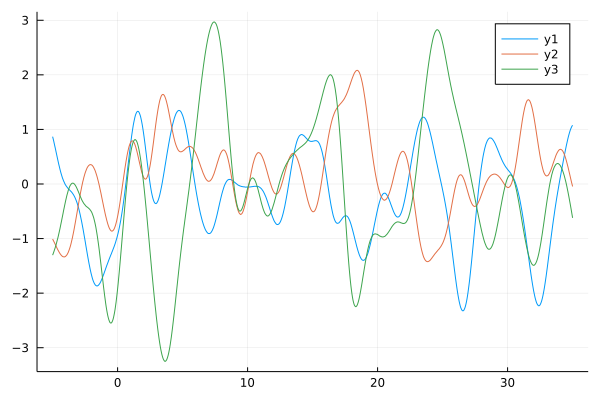

In [8]:
xs = range(-5, 35; length=1000)
sample_prior(xs, 3, gp)

Intuitively, we can think of each of these samples as a function, and so our GP is just a multivariate Gaussian over the *function space*.

### Posterior

We now build some functionality for computing the posterior gp as well as some other valuable measures. Given our GP is just a high-dimensional *zero mean* multivariate Gaussian, we have
$$p(f | \Sigma ) = \frac{1}{|2\pi\Sigma|}e^{-\frac{1}{2}y^T\Sigma^-1y}$$

In [9]:
function posterior(K, y)
    return (1/(det(2*π*K)))*exp((-0.5)*transpose(y)*inv(K)*y)
end

posterior (generic function with 1 method)

Given these probabilities can be extremely small quantities, often we deal with $log$ likelihoods.

In [10]:
function log_pdf(K, y)
    return log(posterior(K, y))
end

log_pdf (generic function with 1 method)

### Posterior GP and sampler

Given our posterior GP will have a mean vector and covariance matrix, rather than tracking these individually and separately, we will define a new `post_GP` type to contain this information.

In [11]:
struct post_GP
    μ
    Σ
end

Lets say we have training data $D = (X_{train},y_{train})$ and want to make predictions $y_{pred}$ for unobserved $X_{pred}$. We can use the rule for conditional Gaussians to identify the posterior over function values $p(y_{pred} | X_{pred}, X_{train},y_{train})$ using

$$\mu_{post} = (\Sigma_{train}^{-1}\Sigma_{train,pred})^Ty_{train} \space\space\space\space\space\space\space\space and \space\space\space\space\space\space\space\space 
\Sigma_{post} = \Sigma_{pred} - (\Sigma_{train}^{-1}\Sigma_{train,pred})^T\Sigma_{train,pred}$$


We start with a very naive implementation of computing the posterior GP. I plan to add more efficient and numerically sound methods, hopefully comparing the results to highlight the benefits to taking advantage of interesting properties of our covariance matrix, such as Cholesky factorizations or QR factorizations.

In [12]:
function posterior_gp(x_train, y_train, x_pred, gp)
    Σ_tr = cov_mat(gp, x_train)
    Σ_tr_pr = x_cov_mat(gp, x_train, x_pred)
    Σ_pr = cov_mat(gp, x_pred)
    temp = transpose(inv(Σ_tr)*Σ_tr_pr) # not stable
    μ_post = temp*y_train
    Σ_post = Σ_pr - temp * Σ_tr_pr
    return post_GP(μ_post, Symmetric(Σ_post)) # Symmetric required due to some numeric instability of the above operations
end

posterior_gp (generic function with 1 method)

Our sampler can return multiple samples from the posterior. Each sample will be a realization of our posterior GP and can be thought of as a function that could have generated the data. We include each sample's standard deviation as a ribbon.

In [13]:
function sample_posterior(x_train, y_train, x_test, num_samples, gp)
    post_GP = posterior_gp(x_train, y_train, x_test, gp)
    ys = rand(MvNormal(post_GP.μ, post_GP.Σ), num_samples)
    σs = sqrt.(diag(post_GP.Σ))
    return ys, σs
end

sample_posterior (generic function with 1 method)

### Making Predictions

We now make a function to execute predictions for specified inputs that weren't available at training (so previously unseen data).

In [14]:
function predict(x_train, y_train, x_pred, x_start, x_end, gp; interval_length=1000)
    xs = sort(union(range(x_start, x_end; length = interval_length), x_pred))
    post_GP = posterior_gp(x_train, y_train, xs, gp)
    ys = rand(MvNormal(post_GP.μ, post_GP.Σ))
        y_pred = []
    for i in 1:length(xs)
        if xs[i] in x_pred
            append!(y_pred, ys[i])
        end
    end
    return y_pred
end

predict (generic function with 1 method)

### The Data

We will start off by making our toy dataset, by adding some noise to a nonlinear function.

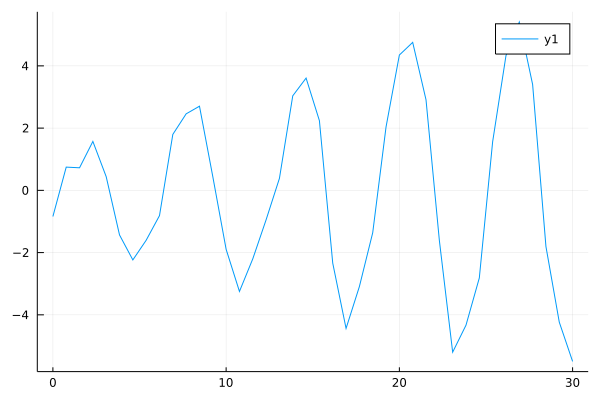

In [15]:
x = range(0,30;length=40);
ϵ = rand(Normal(0,0.5), 40);
y = sqrt.(x).*sin.(x) .+ ϵ;
plot(x,y)

We now have split our data to isolate some training data, as well as some unseen data. We are calling this unseen data "test" data, however it may be more appropriate to imagine it as data we may want to make predictions on later.

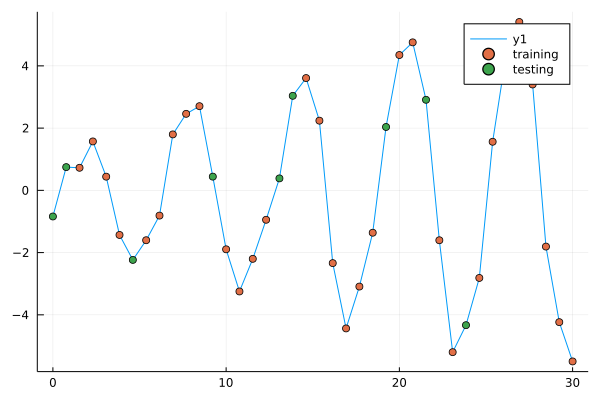

In [16]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

### Now lets take our homemade, fresh out of the oven GP for a spin!

We now have all the pieces of the puzzle (for a very basic GP with extremely limited flexibility) and can see how it performs! We will now try to test out our GP on the data we have created.

In [17]:
p_GP = posterior_gp(x_train, y_train, x_test, gp)

post_GP([1.3296151092881927, -1.4370682301224007, -0.047573921981353434, -5.9742109084333235, 2.3049079695932457, 3.9879240847184625, 0.09178262929934061, 1.4594087308204373, 1.7875405470333638, -0.12263321456071308], [0.027948445547118395 -3.147683000021241e-5 … 0.010329285041852593 -1.1186393378233138e-5; -3.147683000021241e-5 0.020022941891926216 … -0.0011823061861655597 0.01766314028254004; … ; 0.010329285041852593 -0.0011823061861655597 … 0.1288883829059958 -0.0004203206812212788; -1.1186393378233138e-5 0.01766314028254004 … -0.0004203206812212788 0.7981347692460314])

In [18]:
x_pred = range(-5, 35; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp)

([-0.5253354613625638 -1.4194881940377362 0.8001972493489312; -0.5047669017024783 -1.3136855064034634 0.7562492194281473; … ; 0.9158501058010247 -0.17911116442345812 -1.3604860499378033; 0.87333493796561 -0.20808158790792775 -1.310864507817706], [1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875, 1.000000499999875  …  1.000000499080982, 1.0000004993659237, 1.000000499563933, 1.0000004997010725, 1.0000004997957375, 1.000000499860865, 1.0000004999055223, 1.0000004999360417, 1.0000004999568297, 1.000000499970942])

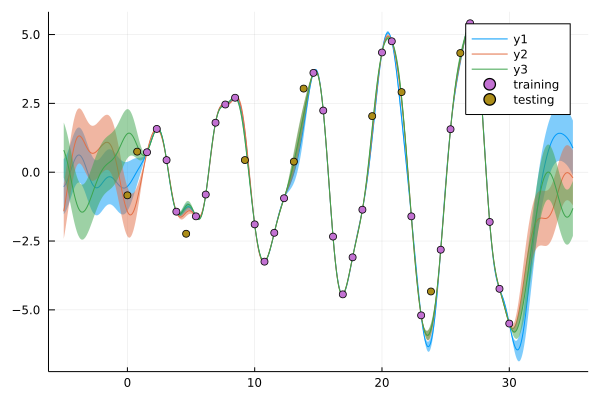

In [19]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

Testing the training method.

In [20]:
x_pred = [0, 1, 10, 11, 12, 20, 25, 29, 34]
y_pred = predict(x_train, y_train, x_pred, 0, 35, gp)

9-element Vector{Any}:
  0.0015156427587712101
 -0.036429885739311205
 -1.8951689560189708
 -3.1095504928935753
 -1.365718289745475
  4.347076962619305
 -0.47070990748587005
 -3.825497596540774
  1.0981147477930335

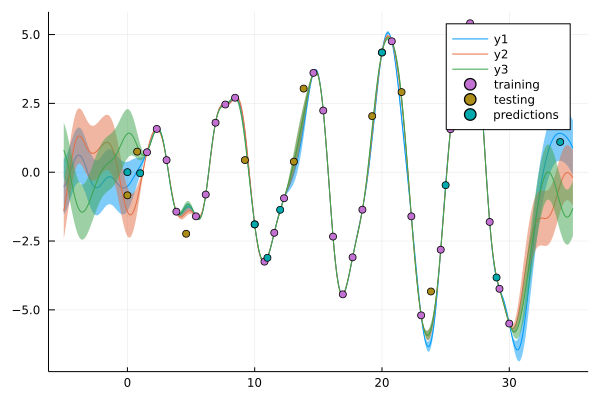

In [21]:
scatter!(x_pred, y_pred, label = "predictions")

### Trying a different (and much more quickly varying) target function

We edit the (hardcoded) hyperparameters of our kernel function to better match our assumptions/knowledge about the function we are trying to model.

In [22]:
function SE_kernel_2(x, x′; σ=1, ℓ=0.001)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel_2 (generic function with 1 method)

In [23]:
gp_2 = GP(SE_kernel_2)

GP(SE_kernel_2)

In [24]:
x = range(0,1;length=40)

0.0:0.02564102564102564:1.0

In [25]:
ϵ = rand(Normal(0,0.5), 40);
y = ℯ.^(x) - 3*tan.(x) .+ ϵ;

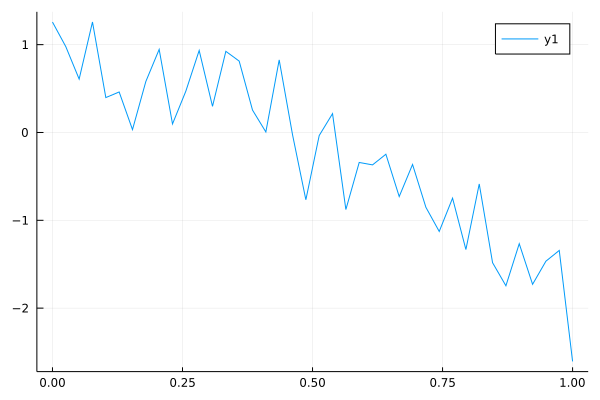

In [26]:
plot(x,y)

In [27]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end

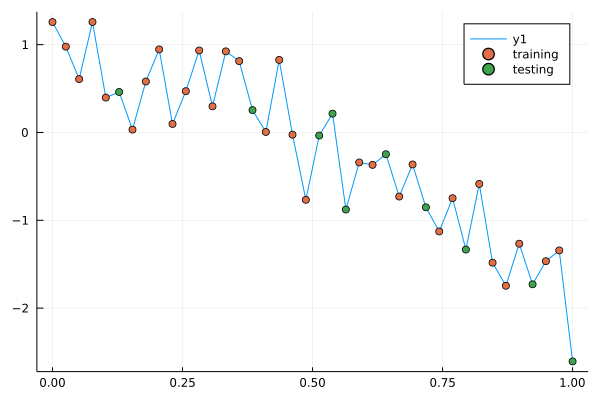

In [28]:
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

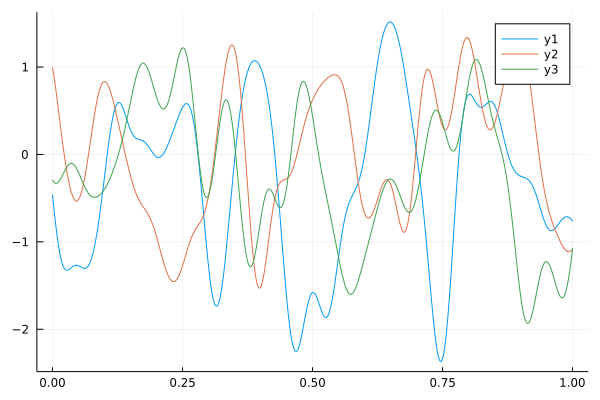

In [29]:
xs = range(0,1;length=1000)
sample_prior(xs,3,gp_2)

In [30]:
p_GP2 = posterior_gp(x_train, y_train, x_test, gp_2)

post_GP([-0.6867979009103691, -0.3723641252760474, -0.45547332203891044, -0.6464712361786238, -0.7236390783996666, -0.2985981985692555, -0.23389963934285513, -0.21082657183126902, -0.30369736393927665, -1.1441801578616433], [0.07100451128946583 0.00014770415504160815 … -3.3373816128689358e-6 0.0009904739674924078; 0.00014770415504160815 0.033443370294275576 … -0.0019650583887206984 6.717066850876482e-7; … ; -3.3373816128689358e-6 -0.0019650583887206984 … 0.03140370088157485 -1.5174715561974653e-8; 0.0009904739674924078 6.717066850876482e-7 … -1.5174715561974653e-8 0.05333460371213661])

In [31]:
x_pred = range(0, 1; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp_2)

([1.2576221910829044 1.257275240673412 1.256917312524124; 1.2802833845441204 1.2818897631189747 1.25735320800122; … ; -1.1506463138134855 -1.2141929325918637 -0.7180570246095712; -1.1421225173328742 -1.2032187729319679 -0.6759932511994813], [0.0014142122870852538, 0.010547610602816037, 0.019872268918271624, 0.028138110562209186, 0.03532707800104836, 0.04144546376582313, 0.046508954453332856, 0.050540383724217555, 0.053569042584952216, 0.055630295178024015  …  0.36262951380971853, 0.3875108069460465, 0.41230292813735997, 0.4369423434409302, 0.46136822079314377, 0.4855226668461437, 0.5093509367933085, 0.5328016166045038, 0.555826777325829, 0.5783821013264107])

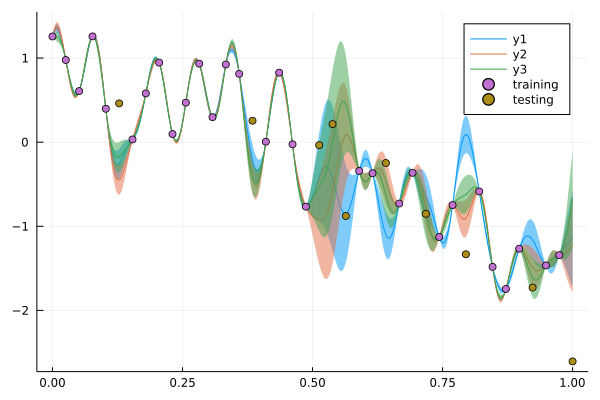

In [32]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

In [33]:
x_pred = [0.125, 0.3, 0.4, 0.5, 0.66, 0.8, 0.95]
y_pred = predict(x_train, y_train, x_pred, 0, 1, gp_2)

7-element Vector{Any}:
 -0.5469130156824636
  0.40214524874113716
 -0.37498859107674615
 -0.7878643603543389
 -0.7876824842612533
 -0.3331099105877765
 -1.4855636940819201

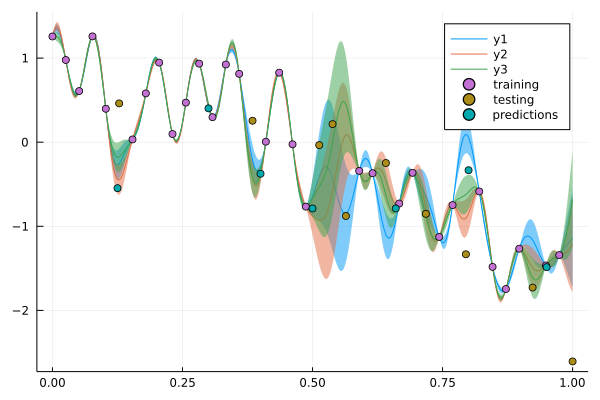

In [34]:
scatter!(x_pred, y_pred; label = "predictions")